In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from tqdm import tqdm
from torch.utils.data import random_split

# 1. Simple Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 2. Dataset Handling
class QuickDrawDataset(Dataset):
    def __init__(self, root_dir, categories, max_samples_per_class=10000):
        self.root_dir = root_dir
        self.categories = categories
        self.max_samples_per_class = max_samples_per_class
        self.data = []
        self.labels = []
        
        for i, category in enumerate(categories):
            file_name = 'full_numpy_bitmap_' + category + '.npy'
            file_path = os.path.join(root_dir, file_name)
            category_data = np.load(file_path)
            # samples = min(len(category_data), max_samples_per_class)
            samples = len(category_data)
            self.data.append(category_data[:samples])
            self.labels.extend([i] * samples)
        
        self.data = np.vstack(self.data).reshape(-1, 28, 28).astype(np.float32) / 255.0
        self.labels = np.array(self.labels, dtype=np.int64)  # Change to int64

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = torch.from_numpy(self.data[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Ensure label is a LongTensor
        return image, label

# Define categories (you can add more)
categories = ['apple', 'banana', 'car', 'dog', 'house']

# Create dataset and dataloader
full_dataset = QuickDrawDataset('./', categories)
# Define the split ratio (e.g., 80% train, 20% validation)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [17]:

# Initialize model, loss function, and optimizer
input_size = 28 * 28  # 28x28 = 784 pixel images
hidden_size = 256
num_classes = len(categories)

model = SimpleNN(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Now, let's go through this code step by step:

model.eval():

This sets the model to evaluation mode.
It's important because it affects the behavior of certain layers like Dropout and BatchNorm.
In eval mode, Dropout layers don't drop neurons, and BatchNorm uses running statistics instead of batch statistics.


with torch.no_grad():

This context manager disables gradient calculation.
During validation, we don't need to compute gradients because we're not updating the model's parameters.
This saves memory and speeds up computation.


Iterating through the validation loader:

We use a separate val_loader that contains data the model hasn't seen during training.
This helps us assess how well the model generalizes to new, unseen data.


Forward pass:

outputs = model(images): We pass the validation images through the model to get predictions.


Loss calculation:

loss = criterion(outputs, labels): We calculate the loss on validation data.
val_loss += loss.item(): We accumulate the loss over all batches.


Accuracy calculation:

_, predicted = outputs.max(1): We get the predicted class for each image.
val_total += labels.size(0): We count the total number of validation samples.
val_correct += predicted.eq(labels).sum().item(): We count how many predictions were correct.


Final accuracy calculation:

val_accuracy = val_correct / val_total: We compute the overall validation accuracy.



Key Points about Validation:

Frequency: Typically done after each training epoch to track the model's generalization performance over time.
No Parameter Updates: Unlike in training, we don't update the model's parameters based on validation performance.
Overfitting Detection: If training accuracy keeps improving but validation accuracy plateaus or decreases, it's a sign of overfitting.
Model Selection: We often save the model weights that perform best on the validation set, a technique called "model checkpointing".
Early Stopping: If validation performance stops improving for a number of epochs, we might stop training early to prevent overfitting.

By including a validation phase, you get a more realistic assessment of your model's performance on unseen data, which is crucial for understanding how well your model will perform in real-world scenarios.

Epoch 1/10 - Validation: 100%|██████████| 2885/2885 [00:03<00:00, 824.89it/s]


Epoch 1/10
Train Loss: 0.0005, Train Acc: 0.9380
Val Loss: 0.1549, Val Acc: 0.9501


Epoch 2/10 - Validation: 100%|██████████| 2885/2885 [00:06<00:00, 452.73it/s]


Epoch 2/10
Train Loss: 0.0005, Train Acc: 0.9546
Val Loss: 0.1422, Val Acc: 0.9537


Epoch 3/10 - Validation: 100%|██████████| 2885/2885 [00:06<00:00, 452.48it/s]


Epoch 3/10
Train Loss: 0.0004, Train Acc: 0.9595
Val Loss: 0.1358, Val Acc: 0.9560


Epoch 4/10 - Validation: 100%|██████████| 2885/2885 [00:06<00:00, 444.05it/s]


Epoch 4/10
Train Loss: 0.0003, Train Acc: 0.9627
Val Loss: 0.1375, Val Acc: 0.9565


Epoch 5/10 - Validation: 100%|██████████| 2885/2885 [00:06<00:00, 440.24it/s]


Epoch 5/10
Train Loss: 0.0004, Train Acc: 0.9654
Val Loss: 0.1359, Val Acc: 0.9575


Epoch 6/10 - Validation: 100%|██████████| 2885/2885 [00:05<00:00, 531.15it/s]


Epoch 6/10
Train Loss: 0.0003, Train Acc: 0.9674
Val Loss: 0.1368, Val Acc: 0.9578


Epoch 7/10 - Validation: 100%|██████████| 2885/2885 [00:03<00:00, 745.66it/s]


Epoch 7/10
Train Loss: 0.0003, Train Acc: 0.9692
Val Loss: 0.1423, Val Acc: 0.9569


Epoch 8/10 - Validation: 100%|██████████| 2885/2885 [00:03<00:00, 769.36it/s]


Epoch 8/10
Train Loss: 0.0003, Train Acc: 0.9706
Val Loss: 0.1462, Val Acc: 0.9565


Epoch 9/10 - Validation: 100%|██████████| 2885/2885 [00:04<00:00, 589.41it/s]


Epoch 9/10
Train Loss: 0.0003, Train Acc: 0.9720
Val Loss: 0.1517, Val Acc: 0.9556


Epoch 10/10 - Validation: 100%|██████████| 2885/2885 [00:05<00:00, 569.21it/s]


Epoch 10/10
Train Loss: 0.0002, Train Acc: 0.9732
Val Loss: 0.1562, Val Acc: 0.9562


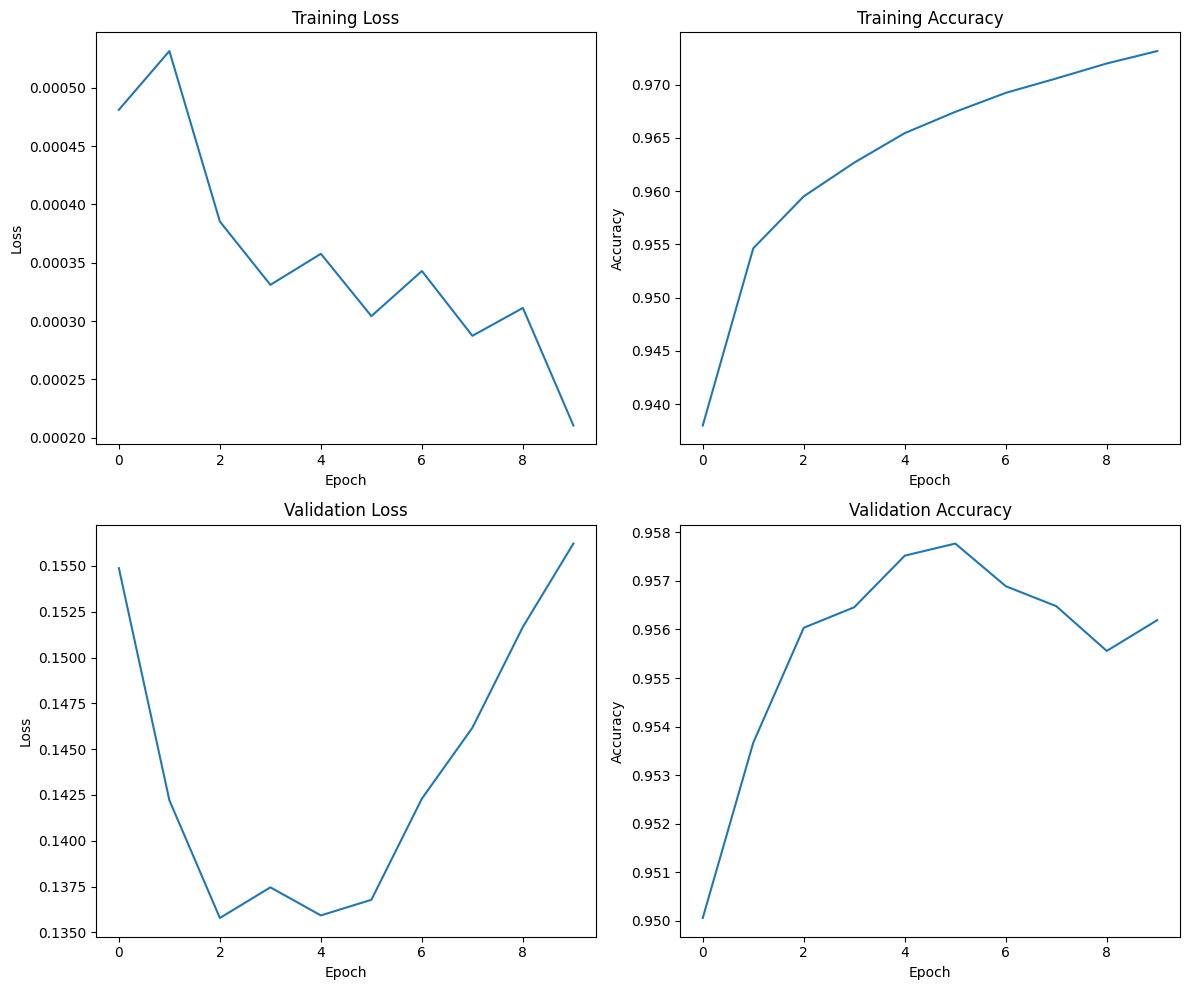

In [18]:
from torch.utils.tensorboard import SummaryWriter
from matplotlib import pyplot as plt
from torch.optim.lr_scheduler import StepLR

writer = SummaryWriter('runs/quickdraw_experiment')

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Lists to store metrics for plotting
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, (images, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Log to TensorBoard every 100 batches
            if i % 100 == 99:
                writer.add_scalar('training loss', running_loss / 100, epoch * len(train_loader) + i)
                writer.add_scalar('accuracy', 100. * correct / total, epoch * len(train_loader) + i)
                running_loss = 0.0
        
        
        # train_accuracy = correct / total
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = val_correct / val_total
        
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {running_loss/len(train_loader):.4f}, Train Acc: {epoch_acc:.4f}")
        print(f"Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_epoch_acc:.4f}")
        
        # Log to TensorBoard
        writer.add_scalars('Loss', {'train': running_loss/len(train_loader), 
                                    'val': val_loss/len(val_loader)}, epoch)
        writer.add_scalars('Accuracy', {'train': epoch_acc, 
                                        'val': val_epoch_acc}, epoch)
        
        # Log model parameters
        for name, param in model.named_parameters():
            writer.add_histogram(name, param, epoch)
            writer.add_histogram(f'{name}.grad', param.grad, epoch)
    
    writer.close()
    
    return train_losses, train_accuracies, val_losses, val_accuracies

# Train the model
model = SimpleNN(input_size=28*28, hidden_size=256, num_classes=len(categories))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Initialize the scheduler
# scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)

# Plotting
# Plotting
plt.figure(figsize=(12, 10))

# Training Loss
plt.subplot(2, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Training Accuracy
plt.subplot(2, 2, 2)
plt.plot(train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Validation Loss
plt.subplot(2, 2, 3)
plt.plot(val_losses)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Validation Accuracy
plt.subplot(2, 2, 4)
plt.plot(val_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.savefig('training_and_validation_metrics.png')
plt.show()

# Log the plot to TensorBoard
writer = SummaryWriter('runs/quickdraw_experiment')
writer.add_figure('training_metrics', plt.gcf())
writer.close()


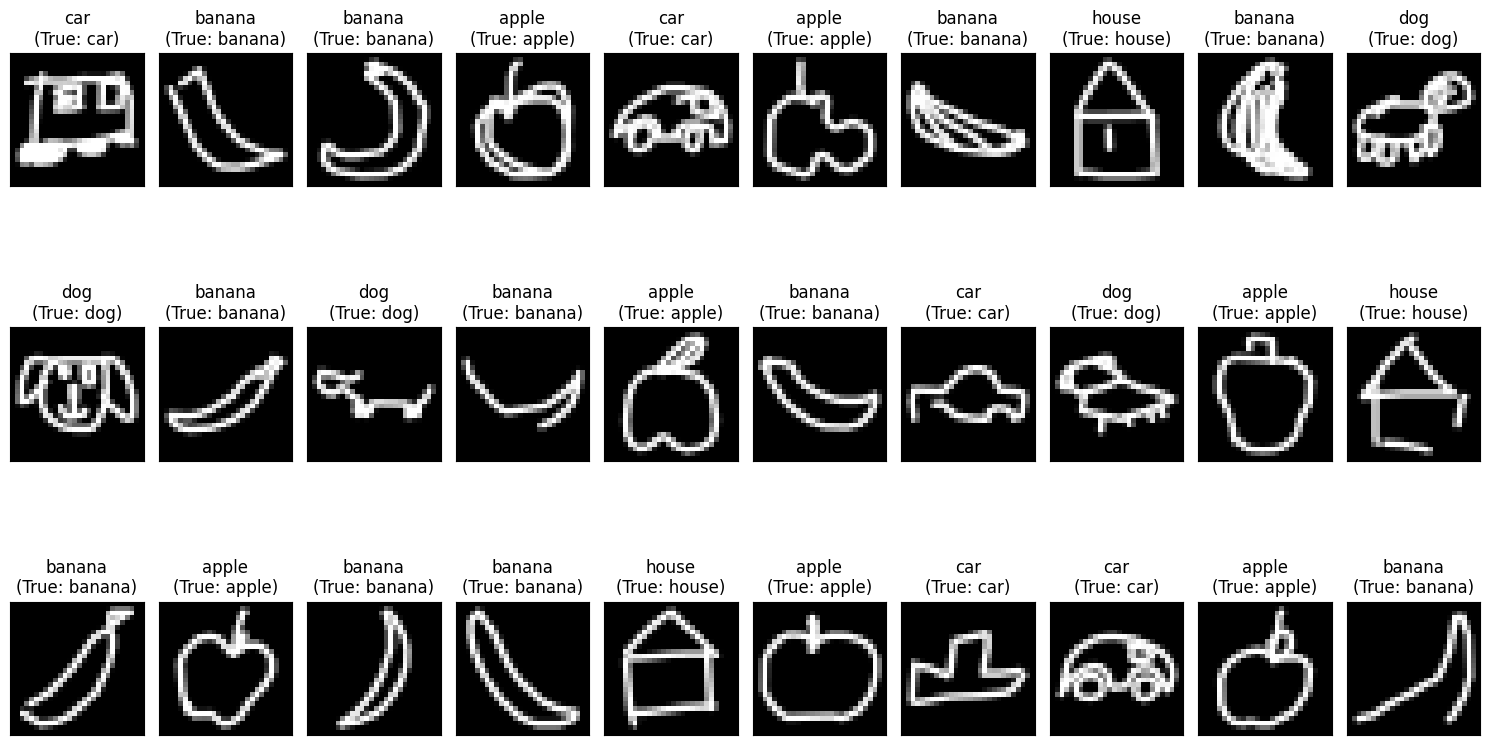

Training complete. You can view the TensorBoard logs by running:
tensorboard --logdir=runs


In [19]:
import math
# Visualize some predictions
def visualize_predictions(model, dataloader, num_images=20):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    images, labels = next(iter(dataloader))
    images = images.to(device)[:num_images]
    labels = labels[:num_images]
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    # Calculate the number of rows and columns for the subplot grid
    num_cols = min(num_images, 10)  # Limit the number of columns to 10 for better visualization
    num_rows = math.ceil(num_images / num_cols)
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
    axes = axes.flatten()  # Flatten the axes array for easy iteration
    
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(images[i].cpu().squeeze(), cmap='gray')
        ax.set_title(f"{categories[predicted[i]]}\n(True: {categories[labels[i]]})")
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Hide any remaining empty subplots
    for i in range(num_images, len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('predictions.png')
    plt.show()
    
    # Log the predictions to TensorBoard
    writer = SummaryWriter('runs/quickdraw_experiment')
    writer.add_figure('predictions', plt.gcf())
    writer.close()

# Example usage
visualize_predictions(model, train_loader, num_images=30)

print("Training complete. You can view the TensorBoard logs by running:")
print("tensorboard --logdir=runs")